In [1]:
from numpy import log as ln
from numpy import random
from matplotlib.ticker import FuncFormatter
from weibullutils import add_median_ranks, plot_weibull_cdf_log_mrr, plot_weibull_cdf_mrr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/Weibull_Suspensions.csv')

In [3]:
df

,VIN,DTF,STATUS
0,6,10,SUSPENDED
1,1,30,FAILED
2,7,45,SUSPENDED
3,2,49,FAILED
4,3,82,FAILED
5,4,90,FAILED
6,5,96,FAILED
7,8,100,SUSPENDED


In [6]:
add_median_ranks(df, 'DTF', 'STATUS')

,VIN,DTF,STATUS,rank,reverse_rank,adjusted_rank,median_rank
0,6,10,SUSPENDED,1,8,NaN,NaN
1,1,30,FAILED,2,7,1.1250,0.098214
2,7,45,SUSPENDED,3,6,NaN,NaN
3,2,49,FAILED,4,5,2.4375,0.254464
4,3,82,FAILED,5,4,3.7500,0.410714
5,4,90,FAILED,6,3,5.0625,0.566964
6,5,96,FAILED,7,2,6.3750,0.723214
7,8,100,SUSPENDED,8,1,NaN,NaN


In [7]:
add_median_ranks(df, 'DTF', 'STATUS').query("median_rank.notna()")

,VIN,DTF,STATUS,rank,reverse_rank,adjusted_rank,median_rank
1,1,30,FAILED,2,7,1.1250,0.098214
3,2,49,FAILED,4,5,2.4375,0.254464
4,3,82,FAILED,5,4,3.7500,0.410714
5,4,90,FAILED,6,3,5.0625,0.566964
6,5,96,FAILED,7,2,6.3750,0.723214


In [8]:
df_final = add_median_ranks(df, 'DTF', 'STATUS').query("median_rank.notna()")

In [9]:
df_final

,VIN,DTF,STATUS,rank,reverse_rank,adjusted_rank,median_rank
1,1,30,FAILED,2,7,1.1250,0.098214
3,2,49,FAILED,4,5,2.4375,0.254464
4,3,82,FAILED,5,4,3.7500,0.410714
5,4,90,FAILED,6,3,5.0625,0.566964
6,5,96,FAILED,7,2,6.3750,0.723214


In [10]:
shape = 2.0242585543715985
scale = 94.99794288911302

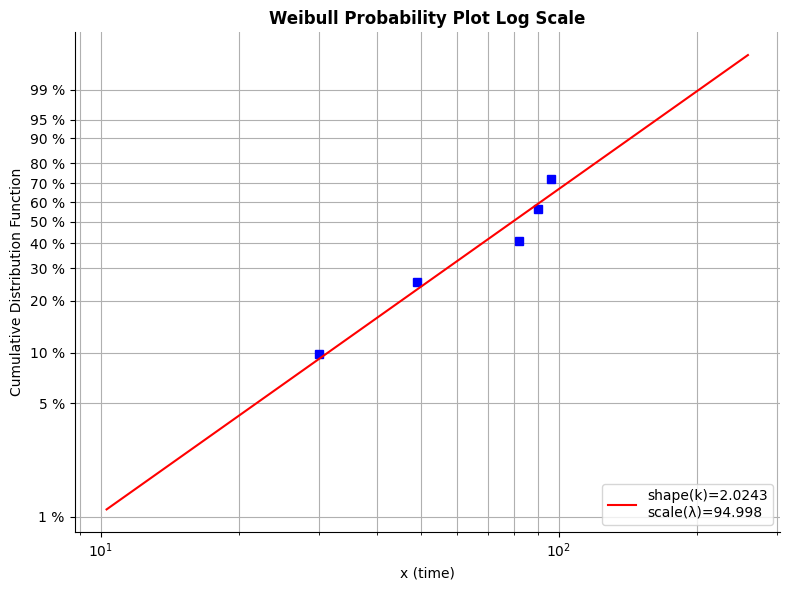

In [12]:
plot_weibull_cdf_log_mrr(df_final, 'DTF', 'median_rank', shape=shape, scale=scale)

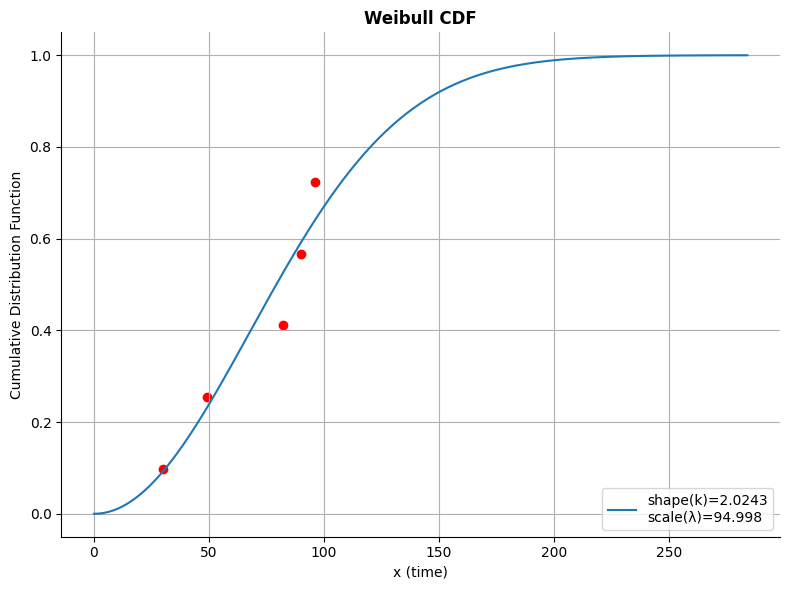

In [13]:
plot_weibull_cdf_mrr(df_final, 'DTF', 'median_rank', shape=shape, scale=scale)